In [1]:
import os
import gc

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import numpy.ma as ma

from hbmep.config import Config
from hbmep.nn import functional as F
from hbmep.model.utils import Site as site

from models import NonHierarchicalBayesianModel
from constants import (
    DATA_PATH,
    TOML_PATH
)

import math


In [2]:
USER = os.environ["USER"]
 
 
src = f"/home/{USER}/repos/rat-mapping-paper/reports/C_SMA_LAR/processed_inference_efficacy.pkl"
with open(src, "rb") as f:
    (
        df,
        encoder_dict,
        model,
        posterior_samples,
        a,
        subjects,
        contacts,
        positions,
        left_degrees,
        size,
    ) = pickle.load(f)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
a.shape #sub, contacts (mono , bi), pos, lat, size

(8, 2, 3, 6, 2, 4000, 6)

In [4]:
contact_ind = 1 # mono or bi
size_ind = 0 # big or small

In [5]:
a = a[:,contact_ind,:,:,size_ind,...]

In [6]:
a.shape

(8, 3, 6, 4000, 6)

In [9]:
a = a / ma.median(a, axis = (1,2,-1), keepdims=True)

In [72]:
a_mean = ma.mean(a, axis=(1,-2))
a_mean.shape

pvalues = []
mask = []
data = []
mean_list = []

for sub_ind, s in enumerate(subjects):
    for l_ind, l in enumerate(left_degrees):
        # if a.mask[sub_ind,pos_ind,l_ind,...].all():
        #         continue
            
        mean_list.append(
            (
                subjects[sub_ind],
                left_degrees[l_ind],
                a_mean[sub_ind,l_ind,...]
            )
        )


In [73]:
a_mean.shape

(8, 6, 6)

In [74]:
t = (a_mean[:, :, None, :] - a_mean[:, None, :, :])
t.shape

(8, 6, 6, 6)

In [66]:
left_degrees

['LL', 'L', 'LM', 'LM1', 'LM2', 'M']

In [75]:
p = stats.ttest_1samp(t, popmean=0, alternative="two-sided", axis=(0,-1)).pvalue
p

array([[       nan, 0.04003572, 0.03050942,        nan,        nan,
               nan],
       [0.04003572,        nan, 0.00524325,        nan,        nan,
               nan],
       [0.03050942, 0.00524325,        nan,        nan,        nan,
               nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan]])

In [55]:
x_vals = {"LL":(-5, 0.005), "L":(-4,0), "LM":(-3,0.005)}

In [49]:
x_vals["L"][1]

0

In [37]:
mean_list[1][2]

masked_array(data=0.9264308889042092,
             mask=False,
       fill_value=1e+20)

(-7.0, 0.0)

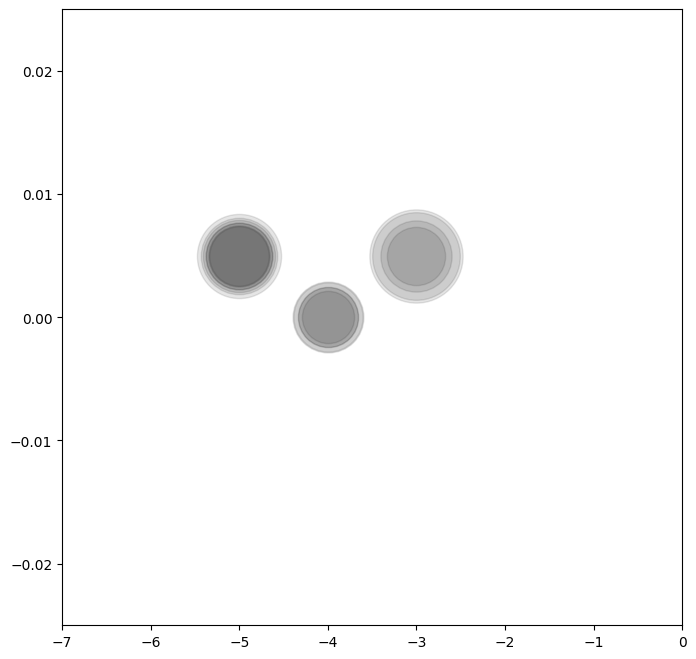

In [56]:
fig, ax = plt.subplots(figsize=(8, 8))

for i, z in enumerate(mean_list):
    if z[1] not in x_vals:
        continue
    eff_size = mean_list[i][2].data
    ax.scatter(x_vals[z[1]][0], x_vals[z[1]][1], s = eff_size*2000,alpha=0.1, color="black")

ax.set_ylim([-0.025, 0.025])
ax.set_xlim([-7, 0])